# 1. Download e tratamento do DataSet

## 1.1. Download dos dados

In [1]:
import os
import gc
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt

# 2. Carregamento do dataset

In [2]:
# Caminhos dos diretórios
train_watermarked_path = 'CLWD/train/Watermarked_image'
train_non_watermarked_path = 'CLWD/train/Watermark_free_image'
test_watermarked_path = 'CLWD/test/Watermarked_image'
test_non_watermarked_path = 'CLWD/test/Watermark_free_image'
results_filename = 'dataaugmentation_autoencoder'

# Parâmetros
batch_size = 32
validation_split = 0.2
img_dim = 64
img_size = (img_dim, img_dim)
steps_per_epoch = (1 - validation_split) * len(os.listdir(train_watermarked_path)) // batch_size
validation_steps = validation_split * len(os.listdir(train_watermarked_path)) // batch_size

In [3]:
def create_dataset(watermarked_path, non_watermarked_path, img_size, batch_size, validation_split=0.2, subset=None, shuffle=True):
    # Lista de arquivos
    watermarked_files = sorted([os.path.join(watermarked_path, f) for f in os.listdir(watermarked_path)])
    non_watermarked_files = sorted([os.path.join(non_watermarked_path, f) for f in os.listdir(non_watermarked_path)])

    # Certifique-se de que os arquivos correspondem em ordem
    assert len(watermarked_files) == len(non_watermarked_files), "Os conjuntos de dados devem ter o mesmo tamanho."
    
    # Determinar índice de divisão
    split_index = int(len(watermarked_files) * (1 - validation_split))

    if subset == "training":
        watermarked_files = watermarked_files[:split_index]
        non_watermarked_files = non_watermarked_files[:split_index]
    elif subset == "validation":
        watermarked_files = watermarked_files[split_index:]
        non_watermarked_files = non_watermarked_files[split_index:]

    # Criar dataset com pares de caminhos
    dataset = tf.data.Dataset.from_tensor_slices((watermarked_files, non_watermarked_files))

    # Função para carregar e pré-processar as imagens
    def preprocess(w_file, nw_file):
        w_img = tf.io.read_file(w_file)
        w_img = tf.image.decode_jpeg(w_img, channels=3)
        w_img = tf.image.resize(w_img, img_size) / 255.0

        nw_img = tf.io.read_file(nw_file)
        nw_img = tf.image.decode_jpeg(nw_img, channels=3)
        nw_img = tf.image.resize(nw_img, img_size) / 255.0

        return w_img, nw_img

    # Aplicar pré-processamento
    dataset = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

    # Adicionar Data Augmentation
    if subset == "training":
        def augment(w_img, nw_img):
            #w_img = tf.image.random_flip_left_right(w_img)
            #w_img = tf.image.random_flip_up_down(w_img)
            w_img = tf.image.random_brightness(w_img, max_delta=0.1)
            w_img = tf.image.random_contrast(w_img, lower=0.9, upper=1.1)
            return w_img, nw_img
        dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

    # Embaralhar se necessário
    if shuffle and subset == "training":
        dataset = dataset.shuffle(buffer_size=1000)

    # Dividir em lotes e aplicar prefetch
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset

# 3. Construção do Autoencoder Convolucional


In [4]:
def build_autoencoder(input_shape=(img_dim, img_dim, 3)):
    input_img = Input(shape=input_shape)

    # Encoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    return autoencoder

# Instanciar o modelo
autoencoder = build_autoencoder()
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
autoencoder.summary()

# Liberação de memória
gc.collect()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       147584

20

# 4. Treinamento do modelo

In [5]:
train_dataset = create_dataset(
    train_watermarked_path, train_non_watermarked_path, 
    img_size, batch_size, validation_split=validation_split, subset="training"
)

val_dataset = create_dataset(
    train_watermarked_path, train_non_watermarked_path, 
    img_size, batch_size, validation_split=validation_split, subset="validation"
)

with tf.device("/device:GPU:0"):
    # Treinamento
    history = autoencoder.fit(
        train_dataset,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_dataset,
        validation_steps=validation_steps,
        epochs=50
    )

Epoch 1/50
1500/1500 [==============================] - 32s 20ms/step - loss: 0.0131 - val_loss: 0.0089
Epoch 2/50
1500/1500 [==============================] - 32s 21ms/step - loss: 0.0094 - val_loss: 0.0070
Epoch 3/50
1500/1500 [==============================] - 32s 21ms/step - loss: 0.0084 - val_loss: 0.0064
Epoch 4/50
1500/1500 [==============================] - 35s 23ms/step - loss: 0.0079 - val_loss: 0.0062
Epoch 5/50
1500/1500 [==============================] - 33s 22ms/step - loss: 0.0076 - val_loss: 0.0061
Epoch 6/50
1500/1500 [==============================] - 34s 22ms/step - loss: 0.0073 - val_loss: 0.0059
Epoch 7/50
1500/1500 [==============================] - 33s 22ms/step - loss: 0.0071 - val_loss: 0.0059
Epoch 8/50
1500/1500 [==============================] - 34s 22ms/step - loss: 0.0069 - val_loss: 0.0054
Epoch 9/50
1500/1500 [==============================] - 33s 21ms/step - loss: 0.0068 - val_loss: 0.0055
Epoch 10/50
1500/1500 [==============================] - 34s 23m

# 5. Avaliação e visualização dos resultados

Imagens salvas em: results\dataaugmentation_autoencoder_training.png


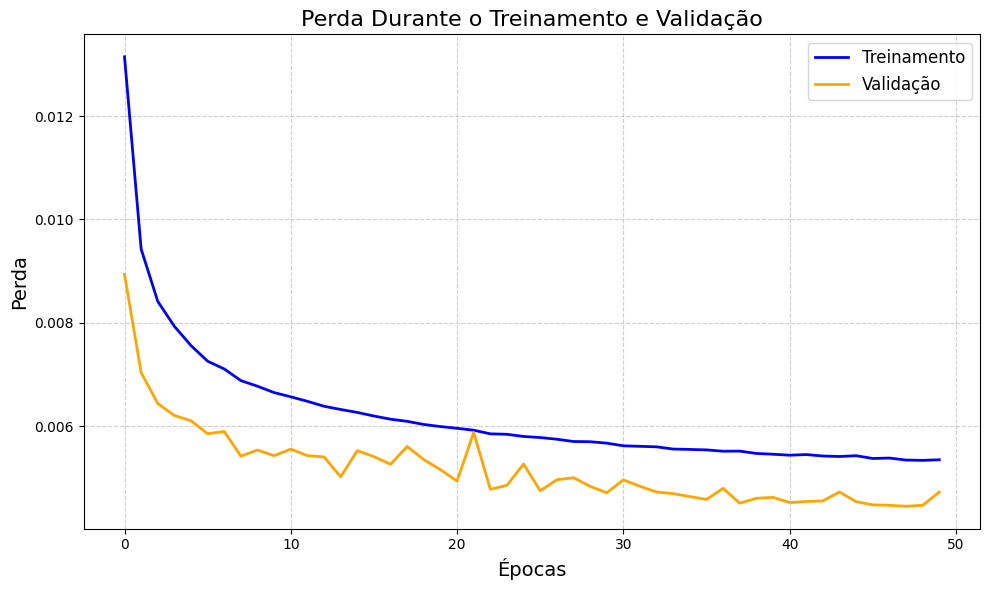

In [6]:
def plot_training_history(history, output_dir="output", file_name="train_history.png"):

    # Cria o diretório de saída, se necessário
    os.makedirs(output_dir, exist_ok=True)
    
    # Caminho completo para salvar o arquivo
    output_path = os.path.join(output_dir, file_name)
    
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Treinamento', color='blue', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validação', color='orange', linewidth=2)
    plt.title('Perda Durante o Treinamento e Validação', fontsize=16)
    plt.xlabel('Épocas', fontsize=14)
    plt.ylabel('Perda', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(output_path)  # Salva o plot no arquivo
    print(f"Imagens salvas em: {output_path}")
    plt.show()
    plt.close()

# Chamando a função após o treinamento
plot_training_history(history, output_dir="results", file_name=results_filename+'_training.png')

In [7]:
def load_image(file_path, img_size):

    image = tf.keras.utils.load_img(file_path, target_size=img_size)
    image = tf.keras.utils.img_to_array(image) / 255.0  # Normaliza para [0, 1]
    return image


def create_test_dataset(watermarked_path, non_watermarked_path, img_size, batch_size):

    # Lista arquivos nos diretórios
    watermarked_files = sorted(os.listdir(watermarked_path), key=lambda x: int(x.split('.')[0]))
    non_watermarked_files = sorted(os.listdir(non_watermarked_path), key=lambda x: int(x.split('.')[0]))
    
    # Verifica se os dois conjuntos possuem o mesmo número de arquivos
    assert len(watermarked_files) == len(non_watermarked_files), \
        "O número de arquivos nos dois diretórios deve ser o mesmo."

    # Carrega as imagens
    watermarked_images = [
        load_image(os.path.join(watermarked_path, file), img_size) for file in watermarked_files
    ]
    non_watermarked_images = [
        load_image(os.path.join(non_watermarked_path, file), img_size) for file in non_watermarked_files
    ]

    # Combina em pares
    dataset = tf.data.Dataset.from_tensor_slices((watermarked_images, non_watermarked_images))
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

# Cria o dataset de teste
test_dataset = create_test_dataset(
    test_watermarked_path, test_non_watermarked_path, img_size, batch_size
)

In [8]:
def evaluate_model_metrics(model, dataset, max_pixel_value=1.0):

    rmse_values = []
    psnr_values = []
    ssim_values = []

    with tf.device("/device:GPU:0"):

        for watermarked, non_watermarked in dataset:
            # Previsão pelo modelo
            reconstructed = model.predict(watermarked, verbose=0)
    
            # Converte para arrays NumPy, se necessário
            y_true = non_watermarked.numpy() if hasattr(non_watermarked, 'numpy') else np.array(non_watermarked)
            y_pred = reconstructed
    
            # Normaliza as imagens, se necessário
            y_true = np.clip(y_true, 0, max_pixel_value)
            y_pred = np.clip(y_pred, 0, max_pixel_value)
    
            # Calcula RMSE
            mse = mean_squared_error(y_true.flatten(), y_pred.flatten())
            rmse = np.sqrt(mse)
            rmse_values.append(rmse)
    
            # Calcula PSNR
            psnr = 20 * np.log10(max_pixel_value / np.sqrt(mse)) if mse > 0 else float('inf')
            psnr_values.append(psnr)
    
            # Calcula SSIM
            ssim_value = ssim(y_true, y_pred, data_range=max_pixel_value, multichannel=True, channel_axis=-1)
            ssim_values.append(ssim_value)

    # Calcula as médias de cada métrica
    metrics = {
        "RMSE": np.mean(rmse_values),
        "PSNR": np.mean(psnr_values),
        "SSIM": np.mean(ssim_values)
    }
    return metrics

# Calcula RMSE no conjunto de treinamento
train_metrics = evaluate_model_metrics(autoencoder, train_dataset)
print("Métricas médias do treinamento:")
print(f"RMSE: {train_metrics['RMSE']:.4f}")
print(f"PSNR: {train_metrics['PSNR']:.2f} dB")
print(f"SSIM: {train_metrics['SSIM']:.4f}")

# Calcula RMSE no conjunto de validacao
val_metrics = evaluate_model_metrics(autoencoder, val_dataset)
print("Métricas médias da validacao:")
print(f"RMSE: {val_metrics['RMSE']:.4f}")
print(f"PSNR: {val_metrics['PSNR']:.2f} dB")
print(f"SSIM: {val_metrics['SSIM']:.4f}")

# Calcula o RMSE no conjunto de teste
test_metrics = evaluate_model_metrics(autoencoder, test_dataset)
print("Métricas médias do teste:")
print(f"RMSE: {test_metrics['RMSE']:.4f}")
print(f"PSNR: {test_metrics['PSNR']:.2f} dB")
print(f"SSIM: {test_metrics['SSIM']:.4f}")

Métricas médias do treinamento:
RMSE: 0.0740
PSNR: 22.63 dB
SSIM: 0.9470
Métricas médias da validacao:
RMSE: 0.0686
PSNR: 23.28 dB
SSIM: 0.9527
Métricas médias do teste:
RMSE: 0.0751
PSNR: 22.50 dB
SSIM: 0.9454


Imagens salvas em: results\dataaugmentation_autoencoder_images.png


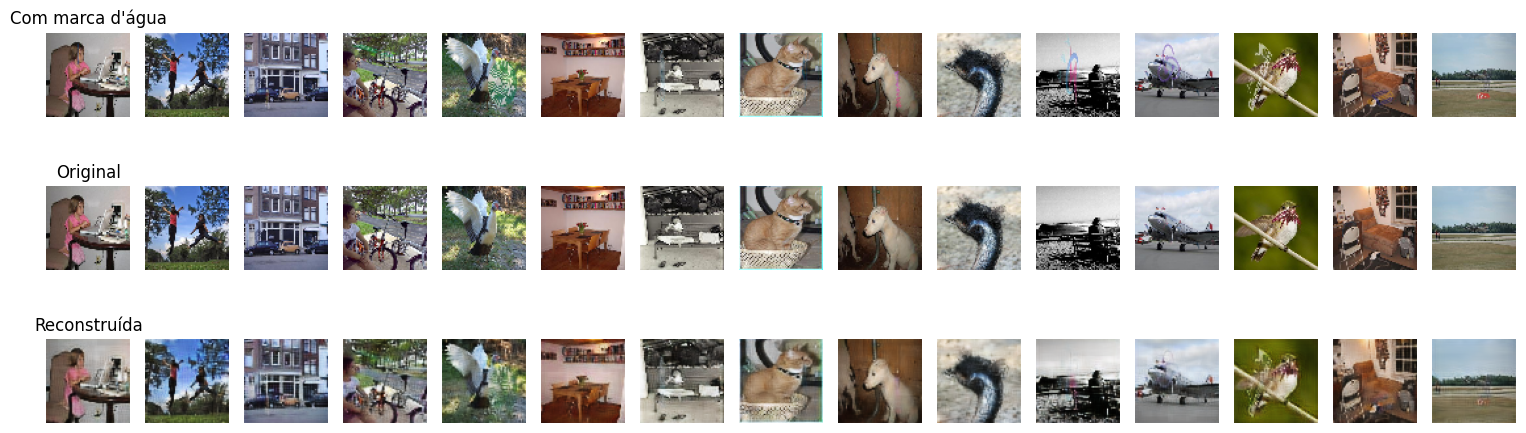

In [9]:
def save_and_show_reconstructed_images(model, test_dataset, num_images=15, output_dir="output", file_name="reconstructed_images.png"):

    # Cria o diretório de saída, se necessário
    os.makedirs(output_dir, exist_ok=True)
    
    # Caminho completo para salvar o arquivo
    output_path = os.path.join(output_dir, file_name)
    
    # Obtém um lote de imagens do dataset de teste
    for watermarked, non_watermarked in test_dataset.take(1):
        # Previsão do modelo
        reconstructed = model.predict(watermarked, verbose=0)

        # Número de imagens a serem plotadas
        num_images = min(num_images, watermarked.shape[0])

        plt.figure(figsize=(15, 5))

        for i in range(num_images):
            # Imagem com marca d'água
            ax = plt.subplot(3, num_images, i + 1)
            plt.imshow(watermarked[i])
            if i == 0:
                plt.title("Com marca d'água")
            plt.axis("off")

            # Imagem original
            ax = plt.subplot(3, num_images, i + 1 + num_images)
            plt.imshow(non_watermarked[i])
            if i == 0:
                plt.title("Original")
            plt.axis("off")

            # Imagem reconstruída
            ax = plt.subplot(3, num_images, i + 1 + 2 * num_images)
            plt.imshow(reconstructed[i])
            if i == 0:
                plt.title("Reconstruída")
            plt.axis("off")

        plt.tight_layout()
        plt.savefig(output_path)  # Salva o plot no arquivo
        print(f"Imagens salvas em: {output_path}")
        plt.show()  # Exibe a figura na tela
        plt.close()  # Fecha a figura para liberar memória
        break  # Apenas um lote é necessário

# Plota 15 imagens do conjunto de teste
save_and_show_reconstructed_images(autoencoder, test_dataset, num_images=15, output_dir="results", file_name=results_filename+'_images.png')

# 6. Salvar o modelo treinado

In [10]:
# Salvar o modelo treinado
autoencoder.save('models/'+results_filename+'.h5')